In [1]:
import numpy as np
import matplotlib.pyplot as plt

from enterprise.signals.signal_base import function as enterprise_function, PTA
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import Uniform
from enterprise.signals.gp_signals import MarginalizingTimingModel
from enterprise.signals.white_signals import MeasurementNoise
from enterprise.pulsar import Pulsar
import enterprise
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import nestle

In [2]:
pwd

'/home/subhajit/Desktop/hypsearch/NanoGrav_open_mdc/run'

In [3]:
#datadir = f"{enterprise.__path__[0]}/datafiles/mdc_open1"
psrname='J2124-3358'
datadir=f"/home/subhajit/Desktop/hypsearch/NanoGrav_open_mdc"
parfile = f"{datadir}/"+psrname+".par"
timfile = f"{datadir}/"+psrname+".tim"

psr = Pulsar(parfile, timfile)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[observatory.C:271] Warning: Assuming site '7' means 'pks'


In [4]:
datadir

'/home/subhajit/Desktop/hypsearch/NanoGrav_open_mdc'

In [5]:
def hms_to_rad(hh, mm, ss):
    sgn = np.sign(hh)
    return sgn * (sgn * hh + mm / 60 + ss / 3600) * np.pi / 12


def dms_to_rad(dd, mm, ss):
    sgn = np.sign(dd)
    return sgn * (sgn * dd + mm / 60 + ss / 3600) * np.pi / 180

In [6]:
from gw_waveform_res import hyp_pta_res

In [7]:
RA_GW = hms_to_rad(4, 0, 0)
DEC_GW = dms_to_rad(-45, 0, 0)
tref1 = (max(psr.toas)+min(psr.toas))/2

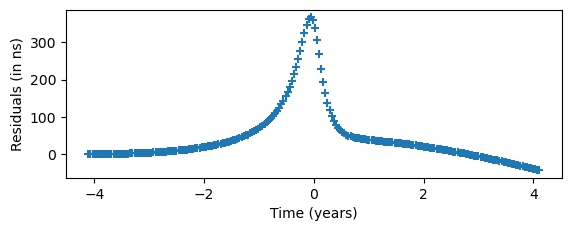

In [8]:
inc0=0;M0=2e10;q0=1;b0=70;e0=1.15;z0=0.3;

hyp_gw =hyp_pta_res(
    cos_gwtheta=np.sin(DEC_GW),
    gwphi=RA_GW,
    psi=0,
    cos_inc=np.cos(inc0),
    log10_M=np.log10(M0),
    q=q0,
    b=b0,
    e0=e0,
    tref=tref1,
    log10_z=np.log10(z0))


hyp_gw_fn = hyp_gw(name="hyp_gw", psr=psr)

res = hyp_gw_fn()

toas = psr.toas / (365.25*24*3600)
t0 = np.mean(toas)

plt.subplot(2,1,1)
plt.scatter(toas-t0, res/1e-9, marker="+")
plt.xlabel('Time (years)')
plt.ylabel('Residuals (in ns)')
plt.show()

In [9]:
import json
import os

import enterprise
import libstempo as lst
import libstempo.plot as lstplot
import libstempo.toasim as toasim
import matplotlib.pyplot as plt
import numpy as np
from gw_waveform_res import hyp_pta_res

In [10]:
output_dir = "gwhyp_sims_try"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [11]:
psrl = lst.tempopulsar(parfile=parfile, timfile=timfile)
print(psrl.name)

[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
J2124-3358


/tmp/ipykernel_3320198/2232959986.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psrl = lst.tempopulsar(parfile=parfile, timfile=timfile)


In [12]:
def save_psr_sim(psr1, savedir):
    print("Writing simulated data for", psr1.name)
    psr1.savepar(f"{savedir}/{psr1.name}_simulate.par")
    psr1.savetim(f"{savedir}/{psr1.name}_simulate.tim")
    lst.purgetim(f"{savedir}/{psr1.name}_simulate.tim")

In [13]:
day_to_s = 24 * 3600

In [14]:
def add_gwecc_1psr(psr):
    toas = (psr.toas() * day_to_s).astype(float)

    signal = (
        np.array(res
            
        )/day_to_s
        
    )

    psr.stoas[:] += signal

    return signal


In [15]:
toasim.make_ideal(psrl)

In [16]:
toasim.add_efac(psrl, 1)

In [17]:
signal = add_gwecc_1psr(psrl)

In [18]:
print("Simulated TOAs for", psrl.name)

Simulated TOAs for J2124-3358


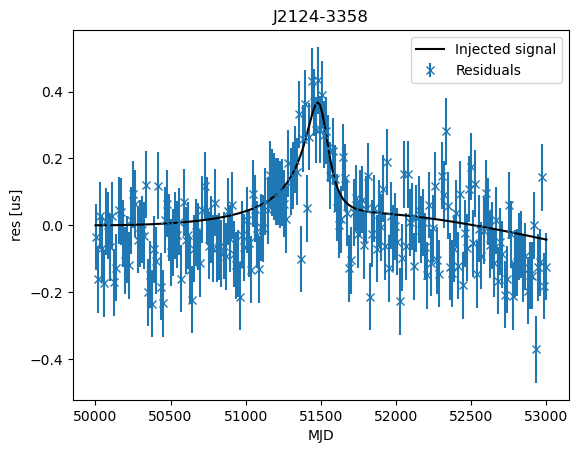

Writing simulated data for J2124-3358


Results for PSR J2124-3358


RMS pre-fit residual = 0.000 (us), RMS post-fit residual = 0.134 (us)
Fit Chisq = 0	Chisqr/nfree = 0.00/0 = -nan	pre/post = 0
Number of fit parameters: 0
Number of points in fit = 0
Offset: 0 1 offset_e*sqrt(n) = 0 n = 0


PARAMETER       Pre-fit                   Post-fit                  Uncertainty   Difference   Fit
---------------------------------------------------------------------------------------------------
RAJ (rad)       5.60569601375114          5.60569601366313          6.5471e-11    -8.8013e-11   Y
RAJ (hms)       21:24:43.8534771           21:24:43.8534771         9.0029e-07    -1.2103e-06  
DECJ (rad)      -0.593046721375533        -0.593046721357358        1.2314e-10    1.8174e-11    Y
DECJ (dms)      -33:58:44.66708           -33:58:44.66708           2.54e-05      3.7487e-06   
F0 (s^-1)       202.793890735157          202.793890735158          7.4112e-14    6.537e-13     Y
F1 (s^-2)       -8.4645

In [19]:
lstplot.plotres(psrl, label="Residuals")
plt.plot(psrl.toas(), signal * day_to_s * 1e6, c="k", label="Injected signal")
plt.title(psrl.name)
plt.legend()
plt.show()

psrl.fit()

save_psr_sim(psrl, output_dir)